# A/B Testing: Player Retention for Mobile Game

## Table of Contents

- [1. Intorduction and Context](#1)
- [2. Imports and Helpers](#2)
- [3. Data](#3)
- [4. Exploratory Data Analysis](#4)
    - [4.1. Player Behaviour - Game Rounds Played](#4.1)
    - [4.2. Player Behaviour - Retention](#4.2)
- [arst](#5)

## 1. Introduction and Context <a name='1'></a>

This is a [mini project](datacamp.com/projects/184) from [DataCamp](datacamp.com). 

### Project Description from DataCamp:

[Cookie Cats](https://tactilegames.com/cookie-cats/) is a hugely popular mobile puzzle game developed by [Tactile Entertainment](https://tactilegames.com). It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats. We're not kidding!

**As players progress through the game they will encounter gates that force them to wait some time before they can progress or alternatively make an in-app purchase to progress. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention.**

🍪 🐈 🍪 🐈 🍪 🐈

### Problem Statement

Should the proposed gate at Level 40 be implemented over the existing gate at Level 40 based on day 1 and 7 player retention rates.

### Data Descriptions

The dataset contains is from 90,189 players that installed the game while the AB Test was running. 

Dataset labels:
- `userid` - `int` - unique player identifier.
- `version` - `str` - group the player was randomly assigned to: control (`gate_30` .- gate at Level 30) or treatment (`gate_40` - gate at Level 40).
- `sum_gamerounds` - `int` - total number of games played by the player during the first week after installation.
- `retention_1` - `bool` - `True` if the player played 1 day after installing else `False`.
- `retention_7` - `bool` - `True` if the player played 7 days after installing else `False`.

## 2. Imports and Helpers<a name='2'></a>

In [1]:
# PyData
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Hypothesis Testing
import scipy.stats as stats

In [2]:
# Global Formatting and rendering
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
sns.set_palette('colorblind')

In [3]:
# Helper Functions

def infoplus(df):
    '''Returns an expanded form of pandas .info() to include,
    shape, null count, null% and unique count'''
    infod = {'col_ind': [], 'col_name': [], 'non_null': [], 'null': [],
             'null_per': [], 'unique': [],'dtype': []}
    max_len = []

    for i, col in enumerate(df.columns):
        infod['col_ind'].append(i)
        infod['col_name'].append(col)
        infod['non_null'].append(df[col].value_counts().sum())
        infod['null'].append(df[col].isna().sum())
        infod['null_per'].append(round(infod['null'][-1] / len(df), 5))
        infod['unique'].append(len(df[col].unique()))
        infod['dtype'].append(str(df[col].dtype))

    for key in infod.keys():
        max_len.append(len(max(map(str, infod[key]), key=len)))
    for i, key in enumerate(infod.keys()):
        max_len[i] = max(len(key), max_len[i])
    if max_len[4] > 6:
        max_len[4] = 6

    OFFSET = 2
    print(type(df))
    print(f'Range Index: {len(df)} entries, {df.index[0]} to {df.index[-1]}')
    print(f'Shape: {df.shape}')
    print(f'''\
{'#': ^{max_len[0] + OFFSET - 2}}\
{'Column': <{max_len[1]}}\
{'Non-Null': >{max_len[2] + OFFSET}}\
{'Null': >{max_len[3] + OFFSET}}\
{'% Null': >{max_len[4] + OFFSET}}\
{'Unique': >{max_len[5] + OFFSET}}  \
{'dtype': <{max_len[6] + OFFSET}}\
''')
    print(f'''\
{'-' * (max(3, max_len[0]) - 2): ^{max_len[0] + OFFSET - 2}}\
{'-' * max_len[1]: <{max_len[1]}}\
{'-' * max_len[2]: >{max_len[2] + OFFSET}}\
{'-' * max_len[3]: >{max_len[3] + OFFSET}}\
{'-' * max_len[4]: >{max_len[4] + OFFSET}}\
{'-' * max_len[5]: >{max_len[5] + OFFSET}}  \
{'-' * max_len[6]: <{max_len[6] + OFFSET}}\
''')
    for i in infod['col_ind']:
        print(f'''{str(infod['col_ind'][i]): ^{max(3, max_len[0] + OFFSET - 2)}}\
{infod['col_name'][i]: <{max_len[1]}}\
{infod['non_null'][i]: >{max_len[2] + OFFSET}}\
{infod['null'][i]: >{max_len[3] + OFFSET}}\
{f"{infod['null_per'][i] * 100: .2f}": >{max_len[4] + OFFSET}}\
{infod['unique'][i]: >{max_len[5] + OFFSET}}  \
{infod['dtype'][i]: <{max_len[6] + OFFSET}}\
              ''')
    
    dtypes = [dtype for dtype in set(infod['dtype'])]
    for dtype in dtypes:
        dtype_count = [f"{dtype}({infod['dtype'].count(dtype)})" for dtype in dtypes]
    print(f"dtypes: {', '.join(dtype_count)}")
    print(f'memory usage: {byte_conversion(df.memory_usage().sum())}')
    
# Helper
def byte_conversion(df_mem):
    '''Converts bytes to readable magnitude, used in infoplus()'''
    ending_dict = {1: 'B', 2: 'KB', 3: 'MB', 4: 'GB'}
    power = 1
    while df_mem / (1024 ** power) > 1:
        power += 1
        if power == 4:
            break
    return f'{df_mem / (1024 ** (power - 1)): .2f} {ending_dict[power]}'

## 3. Data <a name='3'></a>

In [4]:
data = pd.read_csv('../raw_data/cookie_cats.csv')

data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
# Check dataframe shape, null counts and unique values, datatypes
infoplus(data)

<class 'pandas.core.frame.DataFrame'>
Range Index: 90189 entries, 0 to 90188
Shape: (90189, 5)
   #   Column          Non-Null  Null  % Null  Unique  dtype   
 ----- --------------  --------  ----  ------  ------  ------  
   0   userid             90189     0    0.00   90189  int64                 
   1   version            90189     0    0.00       2  object                
   2   sum_gamerounds     90189     0    0.00     942  int64                 
   3   retention_1        90189     0    0.00       2  bool                  
   4   retention_7        90189     0    0.00       2  bool                  
dtypes: object(1), bool(2), int64(2)
memory usage:  2.24 MB


In [6]:
rows = {'rows': False}

list(rows.values())[0]

False

In [7]:
# Check duplicates within data frame and duplicated users
def duplicated_rows_check(df):
    rows = {'name' : 'rows', 'value': False}
    users = {'name' : 'users', 'value': False}
    if df.duplicated().sum() == 0:
        rows['value'] = True
    if df['userid'].duplicated().sum() == 0:
        users['value'] = True
    for check in [rows, users]:
        print(f"No duplicate {check['name']} present." if check['value'] == True
              else f"Duplicate {check['name']} present.")
    return rows['value'], users['value']
    
duplicated_rows_check(data)

No duplicate rows present.
No duplicate users present.


(True, True)

Observations:
- There are no null values.
- `version`, `retention_1` and `retention_7` have binary values as expected.
- There are no duplicate entries or duplicated users.
- Data is generally clean and ready to use.

## 4. Exploratory Data Analysis <a name='4'></a>

### Descriptive Statistics

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


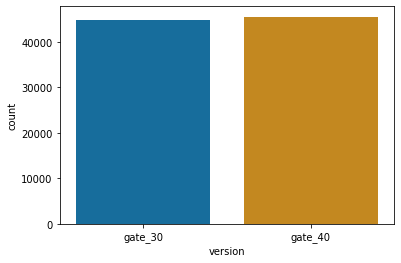

In [8]:
# Coount of players in control and treatment group w/ visualisation

display(data.groupby('version').count())

sns.countplot(x='version', data=data)
plt.show()

In [9]:
# Percentage of players in control and treatment groups

control, treatment = data['version'].value_counts()[0], data['version'].value_counts()[1]
print(f'{control / data.shape[0] * 100:.2f}% of users in control group')
print(f'{treatment / data.shape[0] * 100:.2f}% of users in treatment group')

50.44% of users in control group
49.56% of users in treatment group


Spread of randomly assigned players looks even, though Sample Ratio Mismatch (SRM), could still be present. I will not be performing a SRM analysis, but this could be performed with a Chi-squared goodness of fit test.

In [10]:
# Desptive statistics of the entire data set to get an idea of the distribution

data[['sum_gamerounds']].describe().T

,count,mean,std,min,25%,50%,75%,max
sum_gamerounds,90189.000,51.872,195.051,0.000,5.000,16.000,51.000,49854.000


In [11]:
# Grouped by control and treatment groups

data.groupby('version')['sum_gamerounds'].agg(['count', 'mean', 'median', 'std', 'max'])

,count,mean,median,std,max
version,,,,,
gate_30,44700,52.456,17.000,256.716,49854
gate_40,45489,51.299,16.000,103.294,2640


Looking at the two groups visually, we can see there is an outlier in the `gate_30` group. This will be skewing the data.

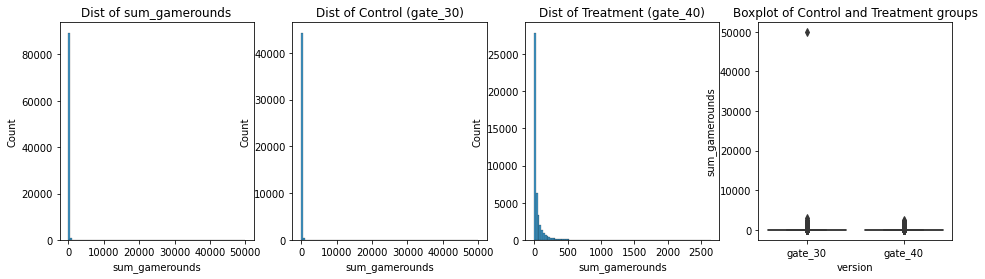

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

sns.histplot(data['sum_gamerounds'], bins=100, ax=axes[0])
sns.histplot(data[data['version'] == 'gate_30']['sum_gamerounds'], bins=100, ax=axes[1])
sns.histplot(data[data['version'] == 'gate_40']['sum_gamerounds'], bins=100, ax=axes[2])
sns.boxplot(x='version', y='sum_gamerounds', data=data, ax=axes[3])

axes[0].set_title('Dist of sum_gamerounds')
axes[1].set_title('Dist of Control (gate_30)')
axes[2].set_title('Dist of Treatment (gate_40)')
axes[3].set_title('Boxplot of Control and Treatment groups')
plt.show()

In [13]:
# Binning sum_gamerounds into 5 arbitrary size bins to get a feel for how many outliers there are

rounds_bins = pd.cut(data['sum_gamerounds'], 5, labels=[i+1 for i in range(5)])
rounds_bins.value_counts().sort_index()

1    90188
2        0
3        0
4        0
5        1
Name: sum_gamerounds, dtype: int64

This means that if the data was sorted into 5 arbitrary but equal bins by `sum_gamecount`, 90,188 of the values would be in bin one, and one value would be in bin five, with no values in bins two, three, or four. 

The data is telling us that a user played ~50,000 games in the first week after downloading, which if true, is kinda impressive. I am are going to remove the outlier.

In [14]:
data = data[data['sum_gamerounds'] < data['sum_gamerounds'].max()]

In [15]:
# Checking descriptive stats of without outlier

display(data.describe().T)
display(data.groupby('version')['sum_gamerounds'].agg(['count', 'mean', 'median', 'std', 'max']))

,count,mean,std,min,25%,50%,75%,max
userid,90188.000,4998396.798,2883297.866,116.000,2512211.250,4995804.000,7496460.750,9999861.000
sum_gamerounds,90188.000,51.320,102.683,0.000,5.000,16.000,51.000,2961.000


,count,mean,median,std,max
version,,,,,
gate_30,44699,51.342,17.000,102.058,2961
gate_40,45489,51.299,16.000,103.294,2640


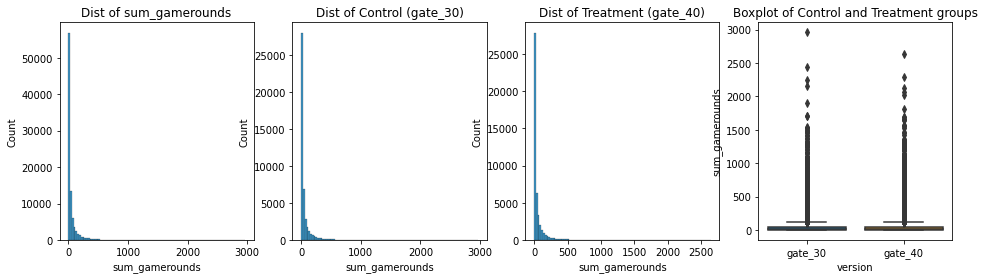

In [16]:
# Re-plotting without outlier

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

sns.histplot(data['sum_gamerounds'], bins=100, ax=axes[0])
sns.histplot(data[data['version'] == 'gate_30']['sum_gamerounds'], bins=100, ax=axes[1])
sns.histplot(data[data['version'] == 'gate_40']['sum_gamerounds'], bins=100, ax=axes[2])
sns.boxplot(x='version', y='sum_gamerounds', data=data, ax=axes[3])

axes[0].set_title('Dist of sum_gamerounds')
axes[1].set_title('Dist of Control (gate_30)')
axes[2].set_title('Dist of Treatment (gate_40)')
axes[3].set_title('Boxplot of Control and Treatment groups')
plt.show()

Boxplots and some stats (mean, std) look more representative of the sample. There is still a skew to the data that we will investigate.

### 4.1 Player Behaviour - Game Rounds Played <a name ='4.1'></a>

The distributions still look heavily skewed, we'll look at some player behaviour.

Starting with the number of players to reach n rounds and a cumulative sum.

In [17]:
# Cumulative sum

game_rounds = data.groupby('sum_gamerounds')['userid'].agg(['count']).reset_index()
game_rounds['percent_count'] = game_rounds['count'] / data.shape[0] * 100
game_rounds['cumsum'] = game_rounds['count'].cumsum()
game_rounds['percent_cumsum'] = game_rounds['cumsum'] / data.shape[0] * 100

In [28]:
game_rounds.head(20)

,sum_gamerounds,count,percent_count,cumsum,percent_cumsum
0,0,3994,4.429,3994,4.429
1,1,5538,6.141,9532,10.569
2,2,4606,5.107,14138,15.676
3,3,3958,4.389,18096,20.065
4,4,3629,4.024,21725,24.089
5,5,2992,3.318,24717,27.406
6,6,2861,3.172,27578,30.578
7,7,2379,2.638,29957,33.216
8,8,2267,2.514,32224,35.730
9,9,2013,2.232,34237,37.962


Looking graphically at the a distribution of players who played between 0 and 100 game rounds (~86 of the sample)

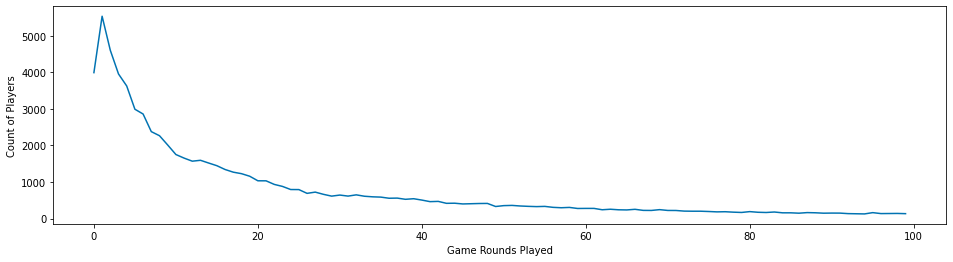

In [29]:
ax = game_rounds[:100].plot(x='sum_gamerounds', y='count', legend=False, figsize=(16,4))
ax.set_xlabel('Game Rounds Played')
ax.set_ylabel('Count of Players')
plt.show()

### Observations on rounds played

The number of players decreases with as the levels increase. The exception is that a number of players installed the game and did not complete a level. All values are with respect to the week after installation.
- 3,994 (~4.4%) players did not play the game
- ~27.4% of players played five or less rounds
- 50% of players played 16 or less rounds
- 75% of players played less than 50 rounds

These values can be explored by themselves, especially the 3,994 players installing the game and not playing in the week following installation, in addition to over a quarter of players in the sample playing 5 rounds or less in the week following installation. Possible reasons may include but aren't limited to:
- Players didn't like the game (mechanics/aesthetics/music).
- Difficulty increased as levels progressed and locked players out.
- Dodn't like the free-mium model.
- Product was not as advertised.
- Players haven't had an opportunity to play the game.

With churn happening at relatively low number of rounds played, there is an opportunity to increase retention. Fact finding (exit surveys) and incentives could lead to higher retention rates. More research is required.

### 4.2 Player Behaviour - Retention <a name ='4.2'></a>